In [1]:
# ============================================================
# 1. Set up Spark Session
# ============================================================

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Seattle911")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/23 03:11:33 WARN Utils: Your hostname, Phongs-MacBook-Pro-23.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.46 instead (on interface en0)
25/11/23 03:11:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 03:11:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/23 03:11:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/23 03:11:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
# ============================================================
# 2. Data Import
# ============================================================

import os
from pathlib import Path

PROJECT_ROOT = Path("../../").resolve()

data_path = PROJECT_ROOT / "data" / "processed" / "calldata_20251019_processed.parquet"

df = spark.read.parquet(str(data_path))
print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")

Loaded 848,167 rows with 22 columns


In [3]:
# ============================================================
# 3. Data Filtering and Feature Setup
# ============================================================
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor

label_col = "First SPD Call Sign Response Time (s)"


raw_feats = [
    'Priority',
    'Dispatch Neighborhood',
    'Dispatch Sector',
    'Count Of Officers',
    'is_rush_hour',
    'is_nighttime',
    'priority_x_officers',
    'priority_x_hour',
    'event_ts',
    'year',
    'month',
    'day',
    'day_of_week',
    'hour',
    'TEMP',
    'PRCP',
    'COCO',
    'weather_severity',
    'is_raining',
    'is_freezing'
]

num_feats = [
    'Priority',
    'Count Of Officers',
    'is_rush_hour',
    'is_nighttime',
    'priority_x_officers',
    'priority_x_hour',
    'year',
    'month',
    'day',
    'day_of_week',
    'hour',
    'TEMP',
    'PRCP',
    'weather_severity',
    'is_raining',
    'is_freezing'
]

cat_feats = ["Dispatch Neighborhood", "Dispatch Sector"]

def to_d(c):
    return F.coalesce(F.col(c).cast("double"), F.lit(0.0))

In [4]:
# ============================================================
# 4. Pipeline: Index → OneHot → Assemble
# ============================================================
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_feats
]
encoders = [
    OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_vec"])
    for c in cat_feats
]
assembled_feats = [f"{c}_vec" for c in cat_feats] + num_feats
assembler = VectorAssembler(inputCols=assembled_feats, outputCol="features")

# Label column
df_labeled = df.withColumn("label", F.col(label_col)).dropna(subset=["label"])

# Split train/test (CV runs only on train)
train, test = df_labeled.randomSplit([0.8, 0.2], seed=42)
train = train.cache()
print(f"Train size: {train.count():,}, Test size: {test.count():,}")

Train size: 678,581, Test size: 169,586


In [5]:
# ============================================================
# 5. Spark XGBoost Setup (5-Fold CV)
# ============================================================

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

num_workers = max(1, len(spark.sparkContext._jsc.sc().statusTracker().getExecutorInfos()) - 1)

xgb = SparkXGBRegressor(
    features_col="features",
    label_col="label",
    objective="reg:squarederror",
    num_workers=num_workers,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    learning_rate=0.05,
    reg_lambda=1.0
)

pipe = Pipeline(stages=indexers + encoders + [assembler, xgb])

# Cross-validation setup
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

param_grid = (
    ParamGridBuilder()
    .addGrid(xgb.n_estimators, [150, 200])
    .addGrid(xgb.max_depth, [6, 8])
    .addGrid(xgb.reg_lambda, [1.0, 2.0])
    .build()
)

cv = CrossValidator(
    estimator=pipe,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=4,
    seed=42
)

In [6]:
# ============================================================
# 6. Fit and Evaluate
# ============================================================
cv_model = cv.fit(train)
best_model = cv_model.bestModel
pred = best_model.transform(test)

from xgboost.spark import SparkXGBRegressorModel

# extract the XGBoost stage from the pipeline
xgb_stage = next(s for s in best_model.stages if isinstance(s, SparkXGBRegressorModel))

print("\nBest XGBoost Stage Params:")
for pname in [
    "n_estimators","max_depth","learning_rate","subsample",
    "colsample_bytree","reg_lambda","reg_alpha",
    "min_child_weight","gamma","max_bin"
]:
    try:
        print(f"{pname}: {xgb_stage.getOrDefault(xgb_stage.getParam(pname))}")
    except:
        pass

# evaluators
from pyspark.ml.evaluation import RegressionEvaluator

e_mae = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae"
).evaluate(pred)

e_rmse = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
).evaluate(pred)

e_mse = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse"
).evaluate(pred)

e_r2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
).evaluate(pred)

print("\n XGBoost (5-fold CV) Results:")
print(f"MAE:                {e_mae:,.2f}")
print(f"RMSE:               {e_rmse:,.2f}")
print(f"MSE:                {e_mse:,.2f}")
print(f"R²:                 {e_r2:,.4f}")

2025-11-23 03:11:43,493 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 8, 'objective': 'reg:squarederror', 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:11:43,513 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'objective': 'reg:squarederror', 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:11:43,527 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'objective': 'reg:


Best XGBoost Stage Params:
n_estimators: 200
max_depth: 8
learning_rate: 0.05
subsample: 0.8
colsample_bytree: 0.8
reg_lambda: 2.0
reg_alpha: None
min_child_weight: None
gamma: None
max_bin: None


2025-11-23 03:15:03,530 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:15:04,960 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:15:05,800 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:15:06,227 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



 XGBoost (5-fold CV) Results:
MAE:                926.33
RMSE:               1,291.16
MSE:                1,667,091.22
R²:                 0.2480



Top 10 Most Important Features:
                                             feature   importance
0                                           Priority  997306304.0
1                                priority_x_officers  159232688.0
2                            Dispatch Sector_vec_BOY  141905616.0
3                           Dispatch Sector_vec_KING  122661184.0
4                                               hour   96175304.0
5      Dispatch Neighborhood_vec_DOWNTOWN COMMERCIAL   93544600.0
6                           Dispatch Sector_vec_MARY   82809456.0
7  Dispatch Neighborhood_vec_JUDKINS PARK/NORTH B...   82061880.0
8                          Dispatch Sector_vec_UNION   74007768.0
9                           Dispatch Sector_vec_JOHN   69687800.0


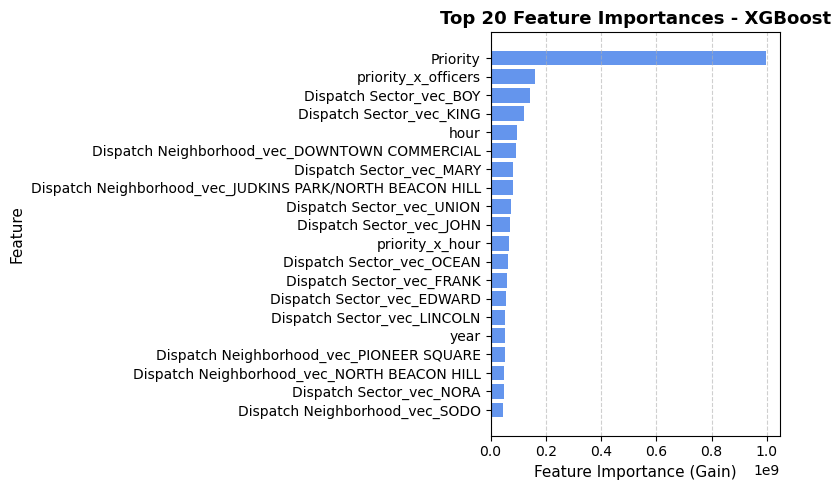

In [7]:
# ============================================================
# 7. Feature Importance Extraction and Plot
# ============================================================
from pyspark.ml.feature import OneHotEncoderModel
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get metadata names from the features column
feat_name_by_idx = {}
try:
    feat_meta = pred.schema["features"].metadata
    if "ml_attr" in feat_meta and "attrs" in feat_meta["ml_attr"]:
        for k in ("binary", "numeric"):
            for a in feat_meta["ml_attr"]["attrs"].get(k, []):
                feat_name_by_idx[a["idx"]] = a.get("name", f"{k}_{a['idx']}")
except Exception as e:
    print("Could not extract metadata from features column:", e)

# Step 2: Fallback: reconstruct names manually if needed
if not feat_name_by_idx:
    print("Reconstructing feature names using OneHotEncoderModel...")
    ohe_models = [s for s in best_model.stages if isinstance(s, OneHotEncoderModel)]
    assert len(ohe_models) == 1, "Expected a single OneHotEncoderModel stage"
    ohe_model = ohe_models[0]

    cat_vec_cols = ohe_model.getOutputCols()
    cat_sizes = ohe_model.categorySizes
    running_idx = 0

    for col_name, size in zip(cat_vec_cols, cat_sizes):
        for j in range(size):
            feat_name_by_idx[running_idx] = f"{col_name}__{j}"
            running_idx += 1

    for ncol in num_feats:
        feat_name_by_idx[running_idx] = ncol
        running_idx += 1

# Step 3: Extract raw feature importance scores from XGBoost
xgb_stage = best_model.stages[-1]
booster = xgb_stage.get_booster()
raw_imp = booster.get_score(importance_type="gain")  # {'f12': 0.123, ...}

imp_rows = []
for fid, val in raw_imp.items():
    try:
        idx = int(fid[1:])  # remove leading 'f'
        name = feat_name_by_idx.get(idx, fid)
    except Exception:
        name = fid
    imp_rows.append((name, float(val)))

imp_df = (
    pd.DataFrame(imp_rows, columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 Most Important Features:")
print(imp_df.head(10))

# Step 4: Plot top 10 features
topk = 20
plt.figure(figsize=(8, 5))
plt.barh(
    imp_df["feature"].head(topk)[::-1],
    imp_df["importance"].head(topk)[::-1],
    color="cornflowerblue"
)
plt.xlabel("Feature Importance (Gain)", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.title("Top 20 Feature Importances - XGBoost", fontsize=13, weight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(PROJECT_ROOT/ "figures" / "xgb_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# ============================================================
# 8. XBG Redo with Top Features Only
# ============================================================

num_feats = [
    'Priority',
    'year',
    'hour',
]

cat_feats = ["Dispatch Neighborhood", "Dispatch Sector"]


indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_feats
]
encoders = [
    OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_vec"])
    for c in cat_feats
]
assembled_feats = [f"{c}_vec" for c in cat_feats] + num_feats
assembler = VectorAssembler(inputCols=assembled_feats, outputCol="features")

# Label column
df_labeled = df.withColumn("label", F.col(label_col)).dropna(subset=["label"])

# Split train/test (CV runs only on train)
train, test = df_labeled.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

cv_model = cv.fit(train)
best_model = cv_model.bestModel
pred = best_model.transform(test)

from xgboost.spark import SparkXGBRegressorModel

# extract the XGBoost stage from the pipeline
xgb_stage = next(s for s in best_model.stages if isinstance(s, SparkXGBRegressorModel))

print("\nBest XGBoost Stage Params:")
for pname in [
    "n_estimators","max_depth","learning_rate","subsample",
    "colsample_bytree","reg_lambda","reg_alpha",
    "min_child_weight","gamma","max_bin"
]:
    try:
        print(f"{pname}: {xgb_stage.getOrDefault(xgb_stage.getParam(pname))}")
    except:
        pass

# evaluators
from pyspark.ml.evaluation import RegressionEvaluator

e_mae = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mae"
).evaluate(pred)

e_rmse = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse"
).evaluate(pred)

e_mse = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="mse"
).evaluate(pred)

e_r2 = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2"
).evaluate(pred)

print("\n📊 XGBoost (5-fold CV) Results:")
print(f"MAE:                {e_mae:,.2f}")
print(f"RMSE:               {e_rmse:,.2f}")
print(f"MSE:                {e_mse:,.2f}")
print(f"R²:                 {e_r2:,.4f}")


MODEL_DIR = PROJECT_ROOT / "models" / "xgb_response_time_pipeline"

best_model.write().overwrite().save(str(MODEL_DIR))
print(f"Saved pipeline model to {MODEL_DIR}")

25/11/23 03:15:07 WARN CacheManager: Asked to cache already cached data.
2025-11-23 03:15:08,004 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'objective': 'reg:squarederror', 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:15:08,014 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.05, 'max_depth': 6, 'objective': 'reg:squarederror', 'reg_lambda': 2.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-23 03:15:08,023 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'colsample_bytree': 0.8, '


Best XGBoost Stage Params:
n_estimators: 200
max_depth: 8
learning_rate: 0.05
subsample: 0.8
colsample_bytree: 0.8
reg_lambda: 2.0
reg_alpha: None
min_child_weight: None
gamma: None
max_bin: None


2025-11-23 03:18:21,041 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:18:22,779 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:18:23,465 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-11-23 03:18:24,200 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



📊 XGBoost (5-fold CV) Results:
MAE:                926.33
RMSE:               1,291.16
MSE:                1,667,091.22
R²:                 0.2480


Saved pipeline model to /Users/nguyenp/Documents/Coding/ISye7406/Project/CODE/models/xgb_response_time_pipeline


25/11/23 03:18:27 WARN TaskSetManager: Stage 1468 contains a task of very large size (4454 KiB). The maximum recommended task size is 1000 KiB.


In [9]:
spark.stop()